# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Goal-of-this-notebook" data-toc-modified-id="Goal-of-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal of this notebook</a></div><div class="lev2 toc-item"><a href="#Load-data,-and-prepare-Timeseries" data-toc-modified-id="Load-data,-and-prepare-Timeseries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data, and prepare Timeseries</a></div><div class="lev1 toc-item"><a href="#Regression-analysis:-eliminate-effect-from-&quot;day_of_week&quot;" data-toc-modified-id="Regression-analysis:-eliminate-effect-from-&quot;day_of_week&quot;-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression analysis: eliminate effect from "day_of_week"</a></div><div class="lev2 toc-item"><a href="#Fit-OLS-model" data-toc-modified-id="Fit-OLS-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit OLS model</a></div><div class="lev2 toc-item"><a href="#Analyze-residual-signal" data-toc-modified-id="Analyze-residual-signal-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyze residual signal</a></div><div class="lev2 toc-item"><a href="#Compute-first-order-difference-in-the-residual" data-toc-modified-id="Compute-first-order-difference-in-the-residual-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Compute first-order difference in the residual</a></div><div class="lev2 toc-item"><a href="#Histograms-of-the-signals" data-toc-modified-id="Histograms-of-the-signals-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Histograms of the signals</a></div><div class="lev1 toc-item"><a href="#Repeat-analysis-for-3-years-period" data-toc-modified-id="Repeat-analysis-for-3-years-period-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Repeat analysis for 3 years period</a></div><div class="lev2 toc-item"><a href="#Try-overlaying-the-annual-plot" data-toc-modified-id="Try-overlaying-the-annual-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Try overlaying the annual plot</a></div><div class="lev1 toc-item"><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></div>

# Goal of this notebook

- In the previous [air-traffic count analysis](http://takwatanabe.me/airtraffic/flight-count-analysis.html), we saw from the plot below that the daily air-traffic signal is heavily influenced by ``day_of_week``
- namely, the time-series takes a huge "dip" on Saturdays, suggesting people tend to fly out less on that day
- This ``day_of_week`` effect may potentially obscure away other interesting patterns in the data.

- In this notebook, we'll aim to **linearly regress out** the effect of ``day_of_week`` by using a linear regression model
- The regressors will be the ``day_of_week``, encoded by a categorical [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) (called ``factor`` in R)
- I'm sure there are other autocorrelatio-based or Fourier-based models that are more suitable for this type of signal, but a simple linear regression is a good starting-point for me, especially with the time constraint.

In [1]:
from IPython.core.display import display, HTML
display(HTML('<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~takanori/1555.embed?link=false&logo=false" height="525px" width="100%"></iframe>'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import plotly.plotly as py
import calendar

from datetime import datetime
from pprint import pprint
from IPython.display import display

import cufflinks as cf
cf.set_config_file(theme='ggplot',sharing='secret')

# utility functions for this project
# see https://github.com/wtak23/airtraffic/blob/master/final_scripts/util/util.py
import util

# limit output to avoid cluttering screen
pd.options.display.max_rows = 20

In [3]:
# name of output files to prepend with
outfile = 'regressing_out_weekday_effect'
period = '11/1/2015 to 10/31/2016' #range of our analysis

## Load data, and prepare Timeseries

- Here I'll quickly repeat the procedure I took in my previous notebook ([link](http://takwatanabe.me/airtraffic/flight-count-analysis1.html#create-timeseries-of-daily-flight-counts))
- please feel free to skip over this section entirely


In [4]:
df_data = util.load_airport_data()

hash_dayofweek = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
df_data['DAY_OF_WEEK'] = df_data['DAY_OF_WEEK'].map(lambda key: hash_dayofweek[key])

 ... load dataframe from 2015-11.zip 
 ... load dataframe from 2015-12.zip 
 ... load dataframe from 2016-01.zip 
 ... load dataframe from 2016-02.zip 
 ... load dataframe from 2016-03.zip 
 ... load dataframe from 2016-04.zip 
 ... load dataframe from 2016-05.zip 
 ... load dataframe from 2016-06.zip 
 ... load dataframe from 2016-07.zip 
 ... load dataframe from 2016-08.zip 
 ... load dataframe from 2016-09.zip 
 ... load dataframe from 2016-10.zip 


In [5]:
# lookup table for the AIRPORT_ID
df_lookup = pd.read_csv('df_lookup.csv') 

# create hash-table to convert Airport "Code" to "City_State" and "Airport-name" 
hash_lookup = df_lookup.set_index('Code')['City_State'].to_dict()
hash_airport = df_lookup.set_index('Code')['Airport'].to_dict()

In [6]:
# create a column containing "YEAR-MONTH-DAY" info
df_data['time'] = ( df_data['YEAR'].astype(str) + '-' 
                  + df_data['MONTH'].astype(str) + '-' 
                  + df_data['DAY_OF_MONTH'].astype(str))

# now we can create time-series of airtraffic counts
ts_flightcounts = pd.DataFrame(df_data['time'].value_counts()).\
    rename(columns={'time':'counts'})
ts_flightcounts.index = ts_flightcounts.index.to_datetime()
ts_flightcounts.sort_index(inplace=True) # need to sort by date

# explicitly add extra date-info as dataframe columns (to apply `groupby` later)
ts_flightcounts['day']= ts_flightcounts.index.day
ts_flightcounts['month']= ts_flightcounts.index.month
ts_flightcounts['day_of_week'] = ts_flightcounts.index.dayofweek

# `dayofweek` uses encoding Monday=0 ... Sunday=6...make this explicit
ts_flightcounts['day_of_week'] = ts_flightcounts['day_of_week'].map({0:'Mon',
                                                                     1:'Tue',
                                                                     2:'Wed',
                                                                     3:'Thu',
                                                                     4:'Fri',
                                                                     5:'Sat',
                                                                     6:'Sun'}).astype(str)

# create hover_text object for plotly
hover_text= (
    ts_flightcounts['month'].astype(str) 
    + '/'  + ts_flightcounts['day'].astype(str)
    + ' (' + ts_flightcounts['day_of_week'] + ')'
).tolist()

- Ok, we are in business. Let's next run our regression analysis.

# Regression analysis: eliminate effect from "day_of_week"

- Here we will apply linear regression using dummy-variables ``day_of_week`` as the regressors.
- If least-squares fit can remove the effect from the regressor variables, we may be able to dig out interesting patterns from the residual-timeseries signal

## Fit OLS model

In [7]:
# as someone with an R background, i love statsmodels :)
import statsmodels.formula.api as smf

# fit OLS model using categorical variables without intercept 
# (so all dummy-variables receive a binary encoder in the design matrix)
mod = smf.ols(formula = 'counts ~ C(day_of_week) - 1',data=ts_flightcounts).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     73.96
Date:                Thu, 12 Jan 2017   Prob (F-statistic):           9.34e-60
Time:                        23:53:07   Log-Likelihood:                -3004.6
No. Observations:                 366   AIC:                             6023.
Df Residuals:                     359   BIC:                             6051.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
C(day_of_week)[Fri]  1.605e+04    124.514    128.866      0.000      1.58e+04  1.63e+04
C(day_of_week)[Mon]  1.604e+04    123.334    130.061      0.000      1.58e+04  1.63e+04
C(day_of_week)[Sat]  1.312e+04    124.514    105.345      0.000      1.29e+04  1.34e+04
C(day_of_week)[Sun]  1.518e+04    123.334    123.110      0.000      1.49e+04  1.54e+04
C(day_of_week)[Thu]  1.599e+04    124.514    128.415      0.000      1.57e+04  1.62e+04
C(day_of_week)[Tue]  1.578e+04    124.514    126.740      0.000      1.55e+04   1.6e+04
C(day_of_week)[Wed]  1.595e+04    124.514    128.122      0.000      1.57e+04  1.62e+04
==============================================================================
Omnibus:                      138.226   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.535
Skew:                          -1.478   Prob(JB):                    5.39e-175
Kurtosis:                       9.625   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- There are some interesting remarks I can make about the above summary, but let's just focus on the residual timeseries signal from this regression model.

## Analyze residual signal

In [8]:
# add residual signal to our timeseries dataframe
ts_flightcounts['residual'] = mod.resid


title = 'Residual Signal in the Daily Airflight Counts ({})'.format(period)
title+= '<br>(`day_of_week` used as regressors)'
ts_flightcounts.iplot(y=['residual'],
                      filename=outfile+'plot_resid',
                      text=hover_text,
                      color='green',
                      title=title)

In [9]:
title = 'Residual Signal in the Daily Airflight Counts ({})'.format(period)
title+= '<br>(original signal overlaid in secondary y-axes)'

fig1 = ts_flightcounts.iplot(columns=['counts'],   text=hover_text, color='pink',asFigure=True)
fig2 = ts_flightcounts.iplot(columns=['residual'], text=hover_text, color='green',
                             secondary_y=['residual'], asFigure=True,title=title)
fig2['data'].extend(fig1['data'])
py.iplot(fig2,filename=outfile+'residual-overlaid')

- The cyclical effect from ``day_of_week`` has been fairly suppressed.

- The dominant *spikes* that in the residual occurs right around National holidays (eg, Thanksgiving, Independence day), which makes sesne  
  
  - many folks, myself included, tend to fly out during these vacation time :)

## Compute first-order difference in the residual

- Let's take this a step further, and compute the first-order difference in the residual
- this is given by: ``resid_lag[t] = resid[t] - resid[t-1]``
- (coming from an electrical engineering background, I interpret this as a high-pass filtering operation)

In [10]:
# also add "lagged" residual information
ts_flightcounts['resid_diff'] = \
    ts_flightcounts['residual'].shift(1) - ts_flightcounts['residual']
    
title = 'First-order difference of the Residual Signal (`day_of_week` used as regressors)'
title+= '<br>(left click to zoom on figure; shaded region = +/-1.5 std-dev)'

annotations = {
    datetime(2015,11,26):'Thanksgiving',
    datetime(2015,12,24):'Christmas Eve',
    datetime(2015,12,31):'New Years',
    datetime(2016, 2, 7):'??? Something happen ???',
    datetime(2016, 5,29):'Memorials Day',
    datetime(2016, 7, 3):'Independence Day',
    datetime(2016, 9, 4):'Labor Day',
}

std_ = ts_flightcounts['resid_diff'].std() # std-deviation

ts_flightcounts['resid_diff'].iplot(
    filename=outfile+'resid_diff',
    annotations=annotations,
    color = 'blue',
    #hspan=[(-1.5*std_,1.5*std_)],
    hspan = dict(y0=-1.5*std_,y1=1.5*std_,opacity=0.15,color='magenta',fill=True),
    text=hover_text,
    title=title)

- Pretty neat! The national holidays appear as salient "*spikes*" in the signal!

- There are some other mild "spikes" occuring at days I am not familiar with (e.g., was February 7th last year a special day?)


In [11]:
title = 'Lagged Residual Signal in the Daily Airflight Counts ({})'.format(period)
title+= '<br>(original signal overlaid in secondary y-axes; left click to select zooming region)'

fig1 = ts_flightcounts.iplot(columns=['counts'],   text=hover_text, color='pink',asFigure=True)
fig2 = ts_flightcounts.iplot(columns=['resid_diff'], text=hover_text, color='blue',
                             secondary_y=['resid_diff'], asFigure=True,title=title)
fig2['data'].extend(fig1['data'])
py.iplot(fig2,filename=outfile+'resid_diff-overlaid')

In [12]:
#| below create stacked subplot...not that interesting, so comment out
# title = 'Flight counts'
# ts_flightcounts.iplot(y=['counts','residual','resid_diff'],
#                       subplots=True, shape=(3,1),
#                       text=hover_text,
#                       shared_xaxes=True, 
#                       title=title,
#                       filename=outfile+'flightcounts_subplot')

## Histograms of the signals

- The *spike* detection approach above seems like an "anomaly detection" or "outlier detection problem.

- Since there are several (heuristic) outlier detection method that relies on normality assumptions, let's quickly study the distribution of the time series signal



In [13]:
from plotly.tools import FigureFactory as FF

columns = ['counts','residual','resid_diff']
colors  = ['red','green','blue']
group_data = map(lambda col: ts_flightcounts[col].dropna().values,columns)
fig = FF.create_distplot(group_data,
                         group_labels=columns,
                         bin_size= 500,
                         colors=colors,
                         curve_type='kde',#'kde' or 'normal'
)

title = 'Distributions among the three quantities of interest ({})'.format(period)
title+= '<br>(first-order difference in the residual looks pretty heavy tailed...)'

fig['layout'].update(title=title)
py.iplot(fig, filename=outfile+'histogram2')

- the above plot shows ``resid_diff`` is indeed heavy-tailed, as the tails correspond to the major holiday
- (perhaps an [subexponential distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution))

# Repeat analysis for 3 years period

- Just for kicks, I further downloaded data over 2 additional years (from Nov2013-Oct2015), to see if similar pattern appeared in previous years.

- The code below is merely a carbon copy of the above

In [14]:
df_data = util.load_airport_data_3years()
period = '11/1/2013 to 10/31/2016' #range of our analysis

 ... load dataframe from 2013-11.zip 
 ... load dataframe from 2013-12.zip 
 ... load dataframe from 2014-01.zip 
 ... load dataframe from 2014-02.zip 
 ... load dataframe from 2014-03.zip 
 ... load dataframe from 2014-04.zip 
 ... load dataframe from 2014-05.zip 
 ... load dataframe from 2014-06.zip 
 ... load dataframe from 2014-07.zip 
 ... load dataframe from 2014-08.zip 
 ... load dataframe from 2014-09.zip 
 ... load dataframe from 2014-10.zip 
 ... load dataframe from 2014-11.zip 
 ... load dataframe from 2014-12.zip 
 ... load dataframe from 2015-01.zip 
 ... load dataframe from 2015-02.zip 
 ... load dataframe from 2015-03.zip 
 ... load dataframe from 2015-04.zip 
 ... load dataframe from 2015-05.zip 
 ... load dataframe from 2015-06.zip 
 ... load dataframe from 2015-07.zip 
 ... load dataframe from 2015-08.zip 
 ... load dataframe from 2015-09.zip 
 ... load dataframe from 2015-10.zip 
 ... load dataframe from 2015-11.zip 
 ... load dataframe from 2015-12.zip 
 ... load da

In [15]:
# create a column containing "YEAR-MONTH-DAY"
df_data['time'] = ( df_data['YEAR'].astype(str) + '-' 
                  + df_data['MONTH'].astype(str) + '-' 
                  + df_data['DAY_OF_MONTH'].astype(str))

In [16]:
# create time-series of airtraffic counts
ts_flightcounts = pd.DataFrame(df_data['time'].value_counts()).rename(columns={'time':'counts'})
ts_flightcounts.index = ts_flightcounts.index.to_datetime()
ts_flightcounts.sort_index(inplace=True) # need to sort by date

# explicitly add extra date-info as dataframe columns (to apply `groupby` later)
ts_flightcounts['day']= ts_flightcounts.index.day
ts_flightcounts['month']= ts_flightcounts.index.month
ts_flightcounts['day_of_week'] = ts_flightcounts.index.dayofweek

# `dayofweek` uses encoding Monday=0 ... Sunday=6...make this explicit
ts_flightcounts['day_of_week'] = ts_flightcounts['day_of_week'].map({0:'Mon',
                                                                     1:'Tue',
                                                                     2:'Wed',
                                                                     3:'Thu',
                                                                     4:'Fri',
                                                                     5:'Sat',
                                                                     6:'Sun'}).astype(str)

# create hover_text object for plotly
hover_text= (
    ts_flightcounts['month'].astype(str) 
    + '/'  + ts_flightcounts['day'].astype(str)
    + ' (' + ts_flightcounts['day_of_week'] + ')'
).tolist()

In [17]:
plt_options = dict(text=hover_text,color='pink')
title = 'Daily Airflight Counts in the US between ' + period
title+= '<br>(hover over plot for dates; left-click to zoom)'

ts_flightcounts.iplot(y='counts',
                      filename=outfile+'plot_flightcounts3yrs',
                      title=title,
                      **plt_options)

In [18]:
mod = smf.ols(formula = 'counts ~ C(day_of_week) - 1',data=ts_flightcounts).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     212.7
Date:                Thu, 12 Jan 2017   Prob (F-statistic):          1.59e-179
Time:                        23:54:48   Log-Likelihood:                -9081.9
No. Observations:                1096   AIC:                         1.818e+04
Df Residuals:                    1089   BIC:                         1.821e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
C(day_of_week)[Fri]  1.652e+04     76.905    214.751      0.000      1.64e+04  1.67e+04
C(day_of_week)[Mon]  1.653e+04     76.905    214.941      0.000      1.64e+04  1.67e+04
C(day_of_week)[Sat]  1.341e+04     76.905    174.351      0.000      1.33e+04  1.36e+04
C(day_of_week)[Sun]   1.56e+04     76.905    202.900      0.000      1.55e+04  1.58e+04
C(day_of_week)[Thu]  1.646e+04     77.151    213.367      0.000      1.63e+04  1.66e+04
C(day_of_week)[Tue]  1.612e+04     77.151    208.939      0.000       1.6e+04  1.63e+04
C(day_of_week)[Wed]  1.627e+04     77.151    210.946      0.000      1.61e+04  1.64e+04
==============================================================================
Omnibus:                      334.890   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1830.024
Skew:                          -1.299   Prob(JB):                         0.00
Kurtosis:                       8.772   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# add residual signal to our timeseries dataframe
ts_flightcounts['residual'] = mod.resid

title = 'Residual Signal in the Daily Airflight Counts ({})'.format(period)
title+= '<br>(`day_of_week` used as regressors)'
ts_flightcounts.iplot(y=['residual'],
                      filename=outfile+'plot_resid_3years',
                      text=hover_text,
                      color='green',
                      title=title)

In [20]:
title = 'Residual Signal in the Daily Airflight Counts ({})'.format(period)
title+= '<br>(original signal overlaid in secondary y-axes)'

fig1 = ts_flightcounts.iplot(columns=['counts'],   text=hover_text, color='pink',asFigure=True)
fig2 = ts_flightcounts.iplot(columns=['residual'], text=hover_text, color='green',
                             secondary_y=['residual'], asFigure=True,title=title)
fig2['data'].extend(fig1['data'])
py.iplot(fig2,filename=outfile+'residual-overlaid_3years')

In [21]:
# also add "lagged" residual information
ts_flightcounts['resid_diff'] = \
    ts_flightcounts['residual'].shift(1) - ts_flightcounts['residual']
    
title = 'First-order difference in the Residual Signal over 3 years period({})(left click to zoom)'.format(period)
title+= '<br>("day-of-week" used as regressors; shaded region = +/-1.5 std-dev)'

std_ = ts_flightcounts['resid_diff'].std()

ts_flightcounts['resid_diff'].iplot(
    filename=outfile+'plot_resid_diff_3years',color='blue',
    hspan = dict(y0=-1.5*std_,y1=1.5*std_,opacity=0.15,color='magenta',fill=True),
    text=hover_text, title=title)

In [22]:
title = 'First-order-difference in Residual Signal ({})'.format(period)
title+= '<br>(original airtraffic signal overlaid in secondary y-axes; left click to zoom)'

fig1 = ts_flightcounts.iplot(columns=['counts'],   text=hover_text, color='pink',asFigure=True)
fig2 = ts_flightcounts.iplot(columns=['resid_diff'], text=hover_text, color='blue',
                             secondary_y=['resid_diff'], asFigure=True,title=title)
fig2['data'].extend(fig1['data'])
py.iplot(fig2,filename=outfile+'resid_diff-overlaid_3years')

In [23]:
columns = ['counts','residual','resid_diff']
colors  = ['red','green','blue']
group_data = map(lambda col: ts_flightcounts[col].dropna().values,columns)
fig = FF.create_distplot(group_data,
                         group_labels=columns,
                         bin_size= 300,
                         colors=colors,
                         curve_type='kde',#'kde' or 'normal'
)

title = 'Distributions among the three quantities of interest ({})'.format(period)

fig['layout'].update(title=title)
py.iplot(fig, filename=outfile+'histogram3years')

## Try overlaying the annual plot

- Turned out plotly's data structure requires the full "year-month-day" information to create a timeseries plot...

- So I'll resort to a static figure creating using Seaborn

In [24]:
# --- add period info ---
display(ts_flightcounts.head())
ts_flightcounts['period'] = np.nan
#ts_flightcounts.isnull().sum()
ts_flightcounts.loc[datetime(2013,11,1):datetime(2014,10,31), 'period'] = 'period1'
ts_flightcounts.loc[datetime(2014,11,1):datetime(2015,10,31), 'period'] = 'period2'
ts_flightcounts.loc[datetime(2015,11,1):datetime(2016,10,31), 'period'] = 'period3'

display(ts_flightcounts.head())
assert ts_flightcounts['period'].isnull().sum() == 0

,counts,day,month,day_of_week,residual,resid_diff
2013-11-01,18215,1,11,Fri,1699.554140,NaN
2013-11-02,13813,2,11,Sat,404.471338,1295.082803
2013-11-03,17031,3,11,Sun,1426.910828,-1022.439490
2013-11-04,18039,4,11,Mon,1508.917197,-82.006369
2013-11-05,17259,5,11,Tue,1139.108974,369.808223


,counts,day,month,day_of_week,residual,resid_diff,period
2013-11-01,18215,1,11,Fri,1699.554140,NaN,period1
2013-11-02,13813,2,11,Sat,404.471338,1295.082803,period1
2013-11-03,17031,3,11,Sun,1426.910828,-1022.439490,period1
2013-11-04,18039,4,11,Mon,1508.917197,-82.006369,period1
2013-11-05,17259,5,11,Tue,1139.108974,369.808223,period1


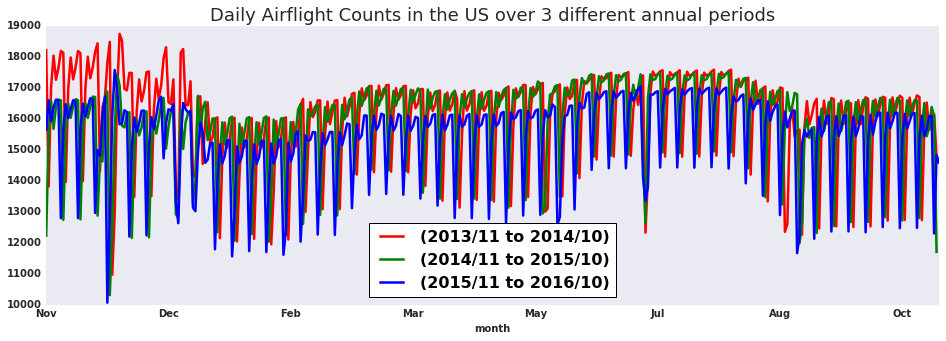

In [25]:
#http://stackoverflow.com/questions/37596714/compare-multiple-year-data-on-a-single-plot-python
#http://man7.org/linux/man-pages/man3/strftime.3.html
ts_flightcounts['month'] = ts_flightcounts.index.to_series().dt.strftime('%b')
util.sns_figure(figsize=(16,5))
ts_flightcounts.query('period == "period1"').plot(x='month',y='counts',label='(2013/11 to 2014/10)',ax=plt.gca(),color='red')
ts_flightcounts.query('period == "period2"').plot(x='month',y='counts',label='(2014/11 to 2015/10)',ax=plt.gca(),color='green')
ts_flightcounts.query('period == "period3"').plot(x='month',y='counts',label='(2015/11 to 2016/10)',ax=plt.gca(),color='blue')
plt.title('Daily Airflight Counts in the US over 3 different annual periods')

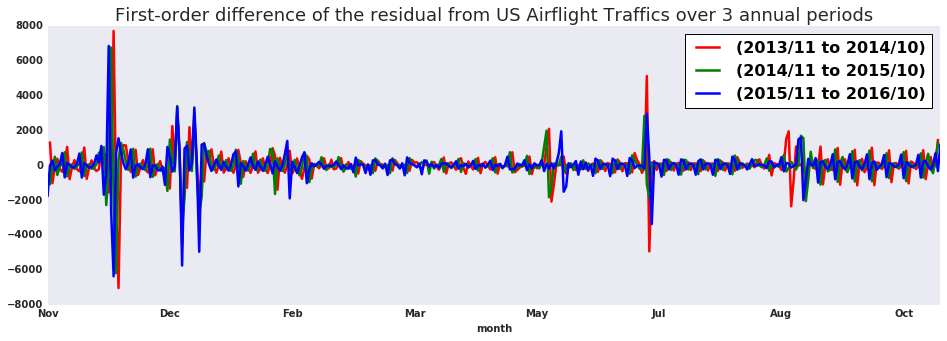

In [27]:
util.sns_figure(figsize=(16,5))
ts_flightcounts.query('period == "period1"').plot(x='month',y='resid_diff',label='(2013/11 to 2014/10)',ax=plt.gca(),color='red')
ts_flightcounts.query('period == "period2"').plot(x='month',y='resid_diff',label='(2014/11 to 2015/10)',ax=plt.gca(),color='green')
ts_flightcounts.query('period == "period3"').plot(x='month',y='resid_diff',label='(2015/11 to 2016/10)',ax=plt.gca(),color='blue')
plt.title('First-order difference of the residual from US Airflight Traffics over 3 annual periods')

# Summary

- using a simple linear regression model with the ``day_of_week`` as the regressors revealed there are **spikes** in the US Airtraffic signal at national holidays
- taking the first-order difference in the residual of the regression model makes the **spike** even more salient
- in the future, I would like to read about autocorrelation model and power-spectral density methods, as these seem appropritae for the type of signal I observed in the above analysis.